## HAR_LSTM model 
#### Add LC candidate from matlab as feature

In [1]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import pickle
from torch.autograd import Variable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 
from sklearn.metrics import classification_report

seed = 7
np.random.seed(seed)

c:\Users\hankk\Miniconda3\envs\py38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = '../Data/'
gpu_use = 'single' ## 'multi', 'single'
gpu_num = 0

In [3]:
## multi-GPU
if gpu_use == 'multi':
    NGPU = torch.cuda.device_count()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## single-GPU
elif gpu_use == 'single':
    device = torch.device("cuda:{}".format(gpu_num) if torch.cuda.is_available() else "cpu")

In [4]:
## Load_data
with open(file_path + 'data_no_std.pkl', 'rb') as f:
     dataset = pickle.load(f)

train_X = dataset[0]
test_X = dataset[1]
train_y = dataset[2]
test_y = dataset[3]

In [5]:
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(2746, 32, 13)
(687, 32, 13)
(2746,)
(687,)


### Model description

- InputLayer (32(timeseries_length)* 13(features))
- LSTM (13*3) or 3times the amount of channel
- Dropout(0.3)
- LSTM (13*3)
- Dense (5)  class num 

In [6]:
## set model(LSTM supervised)

class stacked_LSTM(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(stacked_LSTM, self).__init__()

        self.lstm = nn.LSTM(input_size = in_channel,
                            hidden_size= 13*3,
                            num_layers=2,
                            bias=True,
                            bidirectional=False,
                            batch_first=True,
                            dropout = 0.3)    ## dropout works except last cell

        self.dense = nn.Linear(13*3, out_channel)

    def forward(self, x):
	# Raw x shape : (B, S, F) => (B, 32, 30)
    
        self.lstm.flatten_parameters()
        # Shape : (B, S, H) // H = hidden_size => (B, 64, 128)
        output, (num_layers, hidden_state) = self.lstm(x)
        x = output[:,-1,:]
        # Shape : (B, O) // O = output => (B, 14)
        x = self.dense(x)
        
        return x

In [7]:
## model training 

from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X = torch.Tensor(test_X)
test_y = torch.Tensor(test_y)

# dataset = TensorDataset(X,y)
dataset = TensorDataset(train_X,train_y)
loader = DataLoader(dataset, batch_size = 1000, shuffle=True, drop_last=False)

num_epochs = 2000
lr = 0.002

in_channel=13 ##feature num
out_channel=5 ##output class

## multi GPU    
if gpu_use == 'multi':
    model = stacked_LSTM(in_channel, out_channel)
    if NGPU > 1:
        model = nn.DataParallel(model, device_ids = list(range(NGPU)))
    # torch.multiprocessing.set_start_method('spawn')
    model.to(device)

## single GPU
elif gpu_use == 'single':
    model = stacked_LSTM(in_channel, out_channel).to(device)

criterion = nn.CrossEntropyLoss().to(device) #Loss for multiclass classification
optimizer = optim.Adam(model.parameters(), lr=lr) #optimizer SGD

#Train the model
for epoch in range(num_epochs):
    for train_X,train_y in loader:
        train_X = train_X.to(device)
        train_y = train_y.type(torch.LongTensor)
        train_y = train_y.to(device)
        outputs = model(train_X)
        # obtain loss function
        loss = criterion(outputs, train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 50 == 0:
        print("Epoch: {}, loss:{}".format(epoch, loss.item()))

Epoch: 0, loss:1.531743049621582
Epoch: 50, loss:0.4946631193161011
Epoch: 100, loss:0.23015271127223969
Epoch: 150, loss:0.15053263306617737
Epoch: 200, loss:0.11811041831970215
Epoch: 250, loss:0.12733104825019836
Epoch: 300, loss:0.1101853996515274
Epoch: 350, loss:0.09268595278263092
Epoch: 400, loss:0.07905425131320953
Epoch: 450, loss:0.06888806074857712
Epoch: 500, loss:0.06582445651292801
Epoch: 550, loss:0.05811451002955437
Epoch: 600, loss:0.05812787264585495
Epoch: 650, loss:0.06549841165542603
Epoch: 700, loss:0.03625073283910751
Epoch: 750, loss:0.03788955882191658
Epoch: 800, loss:0.024592630565166473
Epoch: 850, loss:0.04577779024839401
Epoch: 900, loss:0.0333087332546711
Epoch: 950, loss:0.039357710629701614
Epoch: 1000, loss:0.01874730922281742
Epoch: 1050, loss:0.024975208565592766
Epoch: 1100, loss:0.017265385016798973
Epoch: 1150, loss:0.030251186341047287
Epoch: 1200, loss:0.0361485555768013
Epoch: 1250, loss:0.01456370484083891
Epoch: 1300, loss:0.0157699156552553

In [8]:
## Inference for test data 

with torch.no_grad(): #off the autograd / memory 절약, calculation speed up 
    model.eval() #dropout layer와 같이 training / inference 시에 다르게 동작하는 layer를 inference(eval) mode로 바꾸어줌 
    inputs = test_X.to(device)
    outputs = model(inputs)
    print(outputs)
    print(outputs.shape)

tensor([[  6.5586,  -6.1775,  -4.6757,  -2.5267,  -5.7198],
        [  0.1649,  -5.6534,   6.2550,  -5.7103,  -5.8489],
        [  6.4563,  -7.7039,  -2.5512,  -5.7735,  -5.0353],
        ...,
        [ 10.4786,  -5.7973,  -3.8233,  -9.2231, -15.0252],
        [ -1.1778,  -7.3146,   8.5912,  -5.0167,  -4.4561],
        [ -0.1777,  -4.5564,   6.0482,  -6.6269,  -4.8928]])
torch.Size([687, 5])


In [9]:
print(torch.round(F.softmax(outputs, dim=1), decimals=2)) #to represent as prob for each label
pred = outputs.argmax(1).cpu().numpy() #torch tensor to numpy array obj 

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])


In [10]:
# ### Model save and load by pytorch
# path = 'saved_model/'

# ## model save (architecture + param)
# torch.save(model, path+'stacked_LSTM_supervised.pt')

# ## model save (only param)
# torch.save(model.state_dict(), path+'stacked_LSTM_supervised_param.pt')

# ## model load (architecture + param)
# torch.load(path+'stacked_LSTM_supervised.pt')

# ## model load(only param , for same model structure )
# new_model = model #conv1d_lstm model structure
# new_model.load_state_dict(torch.load(path+'stacked_LSTM_supervised_param.pt'))

accuracy:0.9315866084425036
Precision: 0.753663
Recall: 0.674727
F1 score: 0.709045


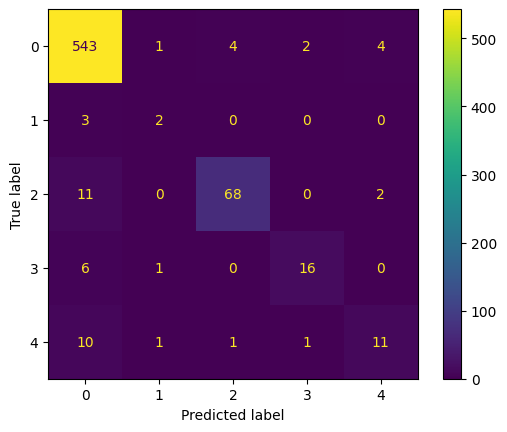

In [11]:
## model evaluation by test set 

oos_y = []
oos_pred = []

test_y.numpy()
oos_y.append(test_y)
oos_pred.append(pred)
y_compare = test_y


score = accuracy_score(y_compare, pred)
print("accuracy:{}".format(score))
precision = precision_score(y_compare, pred, average='macro')
print('Precision: %f' % precision)
recall = recall_score(y_compare, pred, average='macro')
print('Recall: %f' % recall)
f1 = f1_score(y_compare, pred, average='macro')
print('F1 score: %f' % f1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_compare, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [12]:
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96       554
         1.0       0.40      0.40      0.40         5
         2.0       0.93      0.84      0.88        81
         3.0       0.84      0.70      0.76        23
         4.0       0.65      0.46      0.54        24

    accuracy                           0.93       687
   macro avg       0.75      0.67      0.71       687
weighted avg       0.93      0.93      0.93       687



In [13]:
## labels = ['unlabeled', 'acc', 'dec', 'lc_left', 'lc_right']

In [14]:
print(model)

stacked_LSTM(
  (lstm): LSTM(13, 39, num_layers=2, batch_first=True, dropout=0.3)
  (dense): Linear(in_features=39, out_features=5, bias=True)
)


In [15]:
# pred = pd.DataFrame(pred)
# pred.to_csv("pred_results/lstm_results.csv")